#### The Embedding Model

#### 1.1 Loading the model

In [1]:
from sentence_transformers import SentenceTransformer

model_name =  "BAAI/bge-base-en-v1.5"
model = SentenceTransformer(model_name)

model.safetensors:  44%|####4     | 346M/784M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
res = model.encode("RAG is awesome")
print(res.shape)

(768,)


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


#### 1.2 Embeddings in Practice

In [3]:
import numpy as np

def cosine_similarity(vector, vector_array):
    """
    Compute cosine similarity between a given vector and an array of vectors.
    
    Args:
        vector (np.ndarray): A 1D numpy array representing the query vector
        vector_array (np.ndarray): A 2D numpy array where each row is a vector
        
    Returns:
        np.ndarray: Array of cosine similarity scores between the vector and each vector in the array
    """
    # Normalize the query vector
    vector_norm = np.linalg.norm(vector)
    if vector_norm == 0:
        return np.zeros(len(vector_array))
    
    normalized_vector = vector / vector_norm
    
    # Normalize each vector in the array
    vector_array_norms = np.linalg.norm(vector_array, axis=1)
    # Handle zero vectors
    zero_mask = vector_array_norms == 0
    vector_array_norms[zero_mask] = 1  # Avoid division by zero
    
    normalized_vector_array = vector_array / vector_array_norms[:, np.newaxis]
    
    # Compute dot product (cosine similarity for normalized vectors)
    similarities = np.dot(normalized_vector_array, normalized_vector)
    
    # Set similarity to 0 for zero vectors
    similarities[zero_mask] = 0
    
    return similarities

In [4]:
# Example usage of cosine similarity function
sentences = [
    "RAG is awesome",
    "Retrieval Augmented Generation is great",
    "I love machine learning",
    "The weather is nice today",
    "Vector embeddings are useful"
]

# Generate embeddings for all sentences
embeddings = model.encode(sentences)
print(f"Generated {len(embeddings)} embeddings with shape {embeddings[0].shape}")

# Use the first sentence as our query
query_embedding = embeddings[0]
document_embeddings = embeddings[1:]  # All other sentences

# Compute cosine similarities
similarities = cosine_similarity(query_embedding, document_embeddings)

print("\nCosine similarities:")
for i, (sentence, similarity) in enumerate(zip(sentences[1:], similarities)):
    print(f"'{sentences[0]}' vs '{sentence}': {similarity:.4f}")

# Find the most similar sentence
most_similar_idx = np.argmax(similarities)
print(f"\nMost similar sentence: '{sentences[most_similar_idx + 1]}' (similarity: {similarities[most_similar_idx]:.4f})")

Generated 5 embeddings with shape (768,)

Cosine similarities:
'RAG is awesome' vs 'Retrieval Augmented Generation is great': 0.5172
'RAG is awesome' vs 'I love machine learning': 0.5403
'RAG is awesome' vs 'The weather is nice today': 0.5209
'RAG is awesome' vs 'Vector embeddings are useful': 0.4673

Most similar sentence: 'I love machine learning' (similarity: 0.5403)


#### 1.3 Retrieval Metrics

In [5]:
import pandas as pd
import sklearn 

#### Dataset

In [6]:
from sklearn.datasets import fetch_20newsgroups

# Load the 20 Newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

# Convert the dataset to a DataFrame for easier handling
df = pd.DataFrame({
    'text': newsgroups_train.data,
    'category': newsgroups_train.target
})

# Display some basic information about the dataset
print(df.head())
print("\nDataset Size:", df.shape)
print("\nNumber of Categories:", len(newsgroups_train.target_names))
print("\nCategories:", newsgroups_train.target_names)

                                                text  category
0  From: lerxst@wam.umd.edu (where's my thing)\nS...         7
1  From: guykuo@carson.u.washington.edu (Guy Kuo)...         4
2  From: twillis@ec.ecn.purdue.edu (Thomas E Will...         4
3  From: jgreen@amber (Joe Green)\nSubject: Re: W...         1
4  From: jcm@head-cfa.harvard.edu (Jonathan McDow...        14

Dataset Size: (11314, 2)

Number of Categories: 20

Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [7]:
print(f"TEXT:\n\t{df['text'][0]}\nCATEGORY:\n\t{newsgroups_train.target_names[df['category'][0]]}")

TEXT:
	From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





CATEGORY:
	rec.autos


#### Preprocessing and Vectorizing Data

In [8]:
import re
from tqdm import tqdm

def preprocess_text(text):
    """
    Clean and preprocess text data.
    
    Args:
        text (str): Raw text to preprocess
        
    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove email headers and metadata (common in newsgroups)
    text = re.sub(r'^.*?subject:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r'^.*?from:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r'^.*?date:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r'^.*?organization:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r'^.*?lines:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    text = re.sub(r'^.*?nntp-posting-host:.*?\n', '', text, flags=re.MULTILINE | re.IGNORECASE)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    
    # Remove quoted text (lines starting with > or >>)
    text = re.sub(r'^>.*$', '', text, flags=re.MULTILINE)
    
    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    # Remove very short texts (less than 10 characters)
    if len(text) < 10:
        return ""
    
    return text

# Apply preprocessing to the text data
print("Preprocessing text data...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Remove empty texts after preprocessing
df_clean = df[df['cleaned_text'] != ''].copy()
print(f"Original dataset size: {len(df)}")
print(f"After preprocessing: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} empty/short texts")

# Display a sample of cleaned text
print("\nExample of cleaned text:")
print(f"Original:\n{df['text'].iloc[0][:200]}...")
print(f"\nCleaned:\n{df_clean['cleaned_text'].iloc[0][:200]}...")

Preprocessing text data...
Original dataset size: 11314
After preprocessing: 11307
Removed 7 empty/short texts

Example of cleaned text:
Original:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out...

Cleaned:
i was wondering if anyone out there could enlighten me on this car i saw the other day. it was a 2-door sports car, looked to be from the late 60s/ early 70s. it was called a bricklin. the doors were ...
Original dataset size: 11314
After preprocessing: 11307
Removed 7 empty/short texts

Example of cleaned text:
Original:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out...

Cleaned:
i was wondering if anyone out there could enlighten me on this car i saw the other day. it was a 2-do

In [9]:
# Vectorize the cleaned text using the pre-trained sentence transformer model
print("Vectorizing text data using sentence-transformers model...")

# For demonstration, let's use a subset of the data to avoid long processing times
# You can increase this number or remove the limit for full dataset processing
max_samples = 1000
df_subset = df_clean.head(max_samples).copy()

print(f"Processing {len(df_subset)} documents...")

# Generate embeddings for the cleaned text
# Using show_progress_bar=True to display progress
text_embeddings = model.encode(
    df_subset['cleaned_text'].tolist(),
    show_progress_bar=True,
    convert_to_tensor=False,
    normalize_embeddings=True  # Normalize for better similarity computation
)

print(f"\nGenerated embeddings shape: {text_embeddings.shape}")
print(f"Each document is represented as a {text_embeddings.shape[1]}-dimensional vector")

# Add embeddings to the dataframe for easier access
df_subset['embeddings'] = list(text_embeddings)

# Display some statistics
print(f"\nEmbedding statistics:")
print(f"Min value: {text_embeddings.min():.4f}")
print(f"Max value: {text_embeddings.max():.4f}")
print(f"Mean value: {text_embeddings.mean():.4f}")
print(f"Standard deviation: {text_embeddings.std():.4f}")

# Show categories distribution in our subset
category_counts = df_subset['category'].value_counts()
print(f"\nCategory distribution in subset:")
for cat_id, count in category_counts.head(10).items():
    print(f"{newsgroups_train.target_names[cat_id]}: {count} documents")

Vectorizing text data using sentence-transformers model...
Processing 1000 documents...


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Generated embeddings shape: (1000, 768)
Each document is represented as a 768-dimensional vector

Embedding statistics:
Min value: -0.3456
Max value: 0.1493
Mean value: -0.0007
Standard deviation: 0.0361

Category distribution in subset:
soc.religion.christian: 67 documents
comp.sys.mac.hardware: 60 documents
rec.sport.baseball: 56 documents
comp.os.ms-windows.misc: 55 documents
talk.politics.mideast: 55 documents
misc.forsale: 55 documents
rec.autos: 54 documents
sci.electronics: 54 documents
alt.atheism: 54 documents
sci.med: 52 documents


#### Function for retrieval

In [10]:
# Demonstrate retrieval using the vectorized data
def search_similar_documents(query_text, embeddings_df, top_k=5):
    """
    Search for similar documents using cosine similarity.
    
    Args:
        query_text (str): Query text to search for
        embeddings_df (pd.DataFrame): DataFrame containing embeddings
        top_k (int): Number of top similar documents to return
        
    Returns:
        pd.DataFrame: Top similar documents with similarity scores
    """
    # Preprocess and encode the query
    cleaned_query = preprocess_text(query_text)
    query_embedding = model.encode([cleaned_query], normalize_embeddings=True)[0]
    
    # Compute similarities with all documents
    document_embeddings = np.array(embeddings_df['embeddings'].tolist())
    similarities = cosine_similarity(query_embedding, document_embeddings)
    
    # Get top-k most similar documents
    top_indices = np.argsort(similarities)[-top_k:][::-1]
    
    results = embeddings_df.iloc[top_indices].copy()
    results['similarity_score'] = similarities[top_indices]
    
    return results[['cleaned_text', 'category', 'similarity_score']]

# Example search
query = "machine learning and artificial intelligence"
print(f"Searching for: '{query}'")
print("="*50)

similar_docs = search_similar_documents(query, df_subset, top_k=3)

for idx, (_, row) in enumerate(similar_docs.iterrows(), 1):
    category_name = newsgroups_train.target_names[row['category']]
    print(f"\n{idx}. Similarity: {row['similarity_score']:.4f}")
    print(f"   Category: {category_name}")
    print(f"   Text: {row['cleaned_text'][:200]}...")
    print("-" * 80)

Searching for: 'machine learning and artificial intelligence'

1. Similarity: 0.6669
   Category: comp.graphics
   Text: originator: keywords: conference reply-to: (ed breen) australian pattern recognition society 2nd call for papers dicta-93 2nd conference on - digital imaging computing: techniques and applications loc...
--------------------------------------------------------------------------------

2. Similarity: 0.5941
   Category: talk.politics.misc
   Text: in-reply-to: message of sun, 4 apr 93 23:02:33 gmt reply-to: *teddy o'neill-creature with furry hobbit feet from bath uk*, a sentimental fool, posts: with the force of a world-wide youth movement, it ...
--------------------------------------------------------------------------------

3. Similarity: 0.5937
   Category: sci.crypt
   Text: in-reply-to: message of 20 apr 1993 16: 47:03 gmt mark riordan writes: [a list of large-integer arithmetic packages elided] i thought i would note that except lenstra's packages, none of the

c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


#### Retrieving metrics

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

def compute_precision_recall(query_text, expected_category, embeddings_df, top_k=10):
    """
    Compute precision and recall for a single query.
    
    Args:
        query_text (str): Query text
        expected_category (int): Expected category ID for relevant documents
        embeddings_df (pd.DataFrame): DataFrame containing embeddings
        top_k (int): Number of top documents to retrieve
        
    Returns:
        tuple: (precision, recall, retrieved_docs)
    """
    # Get search results
    results = search_similar_documents(query_text, embeddings_df, top_k=top_k)
    
    # Calculate relevant documents in the retrieved set
    relevant_retrieved = sum(results['category'] == expected_category)
    
    # Calculate total relevant documents in the dataset
    total_relevant = sum(embeddings_df['category'] == expected_category)
    
    # Calculate precision and recall
    precision = relevant_retrieved / top_k if top_k > 0 else 0
    recall = relevant_retrieved / total_relevant if total_relevant > 0 else 0
    
    return precision, recall, results

def evaluate_retrieval_system(test_queries, embeddings_df, top_k_values=[5, 10, 20]):
    """
    Evaluate the retrieval system with multiple test queries and different k values.
    
    Args:
        test_queries (list): List of (query_text, expected_category) tuples
        embeddings_df (pd.DataFrame): DataFrame containing embeddings
        top_k_values (list): Different k values to test
        
    Returns:
        dict: Evaluation results
    """
    results = {}
    
    for k in top_k_values:
        precisions = []
        recalls = []
        f1_scores = []
        
        print(f"\nEvaluating with top-{k} retrieval:")
        print("-" * 40)
        
        for i, (query, expected_cat) in enumerate(test_queries, 1):
            precision, recall, _ = compute_precision_recall(query, expected_cat, embeddings_df, top_k=k)
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)
            
            category_name = newsgroups_train.target_names[expected_cat]
            print(f"Query {i}: '{query[:50]}...'")
            print(f"  Category: {category_name}")
            print(f"  Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")
        
        # Calculate average metrics
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_f1 = np.mean(f1_scores)
        
        results[k] = {
            'precision': avg_precision,
            'recall': avg_recall,
            'f1': avg_f1,
            'individual_precisions': precisions,
            'individual_recalls': recalls,
            'individual_f1s': f1_scores
        }
        
        print(f"\nAverage Results for top-{k}:")
        print(f"  Average Precision: {avg_precision:.3f}")
        print(f"  Average Recall: {avg_recall:.3f}")
        print(f"  Average F1-Score: {avg_f1:.3f}")
    
    return results

# Define test queries with their expected categories
# We'll create queries that should match specific newsgroup categories
test_queries = [
    ("computer graphics and image processing", 1),  # comp.graphics
    ("baseball game statistics and players", 9),   # rec.sport.baseball
    ("car engine problems and repairs", 7),        # rec.autos
    ("space mission and NASA news", 15),           # sci.space
    ("medical health advice and symptoms", 13),    # sci.med
    ("christian bible and religious discussion", 19), # soc.religion.christian
    ("political government policy debate", 17),    # talk.politics.misc
    ("computer hardware and electronics", 2),      # comp.sys.mac.hardware
    ("motorcycle riding and maintenance", 8),      # rec.motorcycles
    ("encryption and security software", 4)        # comp.security
]

print("Test Queries and Expected Categories:")
print("=" * 50)
for i, (query, cat_id) in enumerate(test_queries, 1):
    category_name = newsgroups_train.target_names[cat_id]
    print(f"{i}. '{query}' -> {category_name}")

# Run evaluation
evaluation_results = evaluate_retrieval_system(test_queries, df_subset, top_k_values=[5, 10, 20])

Test Queries and Expected Categories:
1. 'computer graphics and image processing' -> comp.graphics
2. 'baseball game statistics and players' -> rec.sport.baseball
3. 'car engine problems and repairs' -> rec.autos
4. 'space mission and NASA news' -> soc.religion.christian
5. 'medical health advice and symptoms' -> sci.med
6. 'christian bible and religious discussion' -> talk.religion.misc
7. 'political government policy debate' -> talk.politics.mideast
8. 'computer hardware and electronics' -> comp.os.ms-windows.misc
9. 'motorcycle riding and maintenance' -> rec.motorcycles
10. 'encryption and security software' -> comp.sys.mac.hardware

Evaluating with top-5 retrieval:
----------------------------------------
Query 1: 'computer graphics and image processing...'
  Category: comp.graphics
  Precision: 1.000, Recall: 0.111, F1: 0.200
Query 2: 'baseball game statistics and players...'
  Category: rec.sport.baseball
  Precision: 1.000, Recall: 0.089, F1: 0.164


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 3: 'car engine problems and repairs...'
  Category: rec.autos
  Precision: 1.000, Recall: 0.093, F1: 0.169
Query 4: 'space mission and NASA news...'
  Category: soc.religion.christian
  Precision: 0.000, Recall: 0.000, F1: 0.000
Query 5: 'medical health advice and symptoms...'
  Category: sci.med
  Precision: 1.000, Recall: 0.096, F1: 0.175


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 6: 'christian bible and religious discussion...'
  Category: talk.religion.misc
  Precision: 0.000, Recall: 0.000, F1: 0.000
Query 7: 'political government policy debate...'
  Category: talk.politics.mideast
  Precision: 0.200, Recall: 0.018, F1: 0.033
Query 8: 'computer hardware and electronics...'
  Category: comp.os.ms-windows.misc
  Precision: 0.000, Recall: 0.000, F1: 0.000


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 9: 'motorcycle riding and maintenance...'
  Category: rec.motorcycles
  Precision: 1.000, Recall: 0.102, F1: 0.185
Query 10: 'encryption and security software...'
  Category: comp.sys.mac.hardware
  Precision: 0.000, Recall: 0.000, F1: 0.000

Average Results for top-5:
  Average Precision: 0.520
  Average Recall: 0.051
  Average F1-Score: 0.093

Evaluating with top-10 retrieval:
----------------------------------------
Query 1: 'computer graphics and image processing...'
  Category: comp.graphics
  Precision: 0.800, Recall: 0.178, F1: 0.291


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 2: 'baseball game statistics and players...'
  Category: rec.sport.baseball
  Precision: 1.000, Recall: 0.179, F1: 0.303
Query 3: 'car engine problems and repairs...'
  Category: rec.autos
  Precision: 1.000, Recall: 0.185, F1: 0.312
Query 4: 'space mission and NASA news...'
  Category: soc.religion.christian
  Precision: 0.000, Recall: 0.000, F1: 0.000


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 5: 'medical health advice and symptoms...'
  Category: sci.med
  Precision: 1.000, Recall: 0.192, F1: 0.323
Query 6: 'christian bible and religious discussion...'
  Category: talk.religion.misc
  Precision: 0.400, Recall: 0.129, F1: 0.195


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 7: 'political government policy debate...'
  Category: talk.politics.mideast
  Precision: 0.300, Recall: 0.055, F1: 0.092
Query 8: 'computer hardware and electronics...'
  Category: comp.os.ms-windows.misc
  Precision: 0.000, Recall: 0.000, F1: 0.000
Query 9: 'motorcycle riding and maintenance...'
  Category: rec.motorcycles
  Precision: 0.900, Recall: 0.184, F1: 0.305


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 10: 'encryption and security software...'
  Category: comp.sys.mac.hardware
  Precision: 0.000, Recall: 0.000, F1: 0.000

Average Results for top-10:
  Average Precision: 0.540
  Average Recall: 0.110
  Average F1-Score: 0.182

Evaluating with top-20 retrieval:
----------------------------------------
Query 1: 'computer graphics and image processing...'
  Category: comp.graphics
  Precision: 0.750, Recall: 0.333, F1: 0.462
Query 2: 'baseball game statistics and players...'
  Category: rec.sport.baseball
  Precision: 0.950, Recall: 0.339, F1: 0.500


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 3: 'car engine problems and repairs...'
  Category: rec.autos
  Precision: 0.950, Recall: 0.352, F1: 0.514
Query 4: 'space mission and NASA news...'
  Category: soc.religion.christian
  Precision: 0.000, Recall: 0.000, F1: 0.000
Query 5: 'medical health advice and symptoms...'
  Category: sci.med
  Precision: 1.000, Recall: 0.385, F1: 0.556


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 6: 'christian bible and religious discussion...'
  Category: talk.religion.misc
  Precision: 0.350, Recall: 0.226, F1: 0.275
Query 7: 'political government policy debate...'
  Category: talk.politics.mideast
  Precision: 0.200, Recall: 0.073, F1: 0.107
Query 8: 'computer hardware and electronics...'
  Category: comp.os.ms-windows.misc
  Precision: 0.000, Recall: 0.000, F1: 0.000


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Query 9: 'motorcycle riding and maintenance...'
  Category: rec.motorcycles
  Precision: 0.850, Recall: 0.347, F1: 0.493
Query 10: 'encryption and security software...'
  Category: comp.sys.mac.hardware
  Precision: 0.050, Recall: 0.017, F1: 0.025

Average Results for top-20:
  Average Precision: 0.510
  Average Recall: 0.207
  Average F1-Score: 0.293


c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


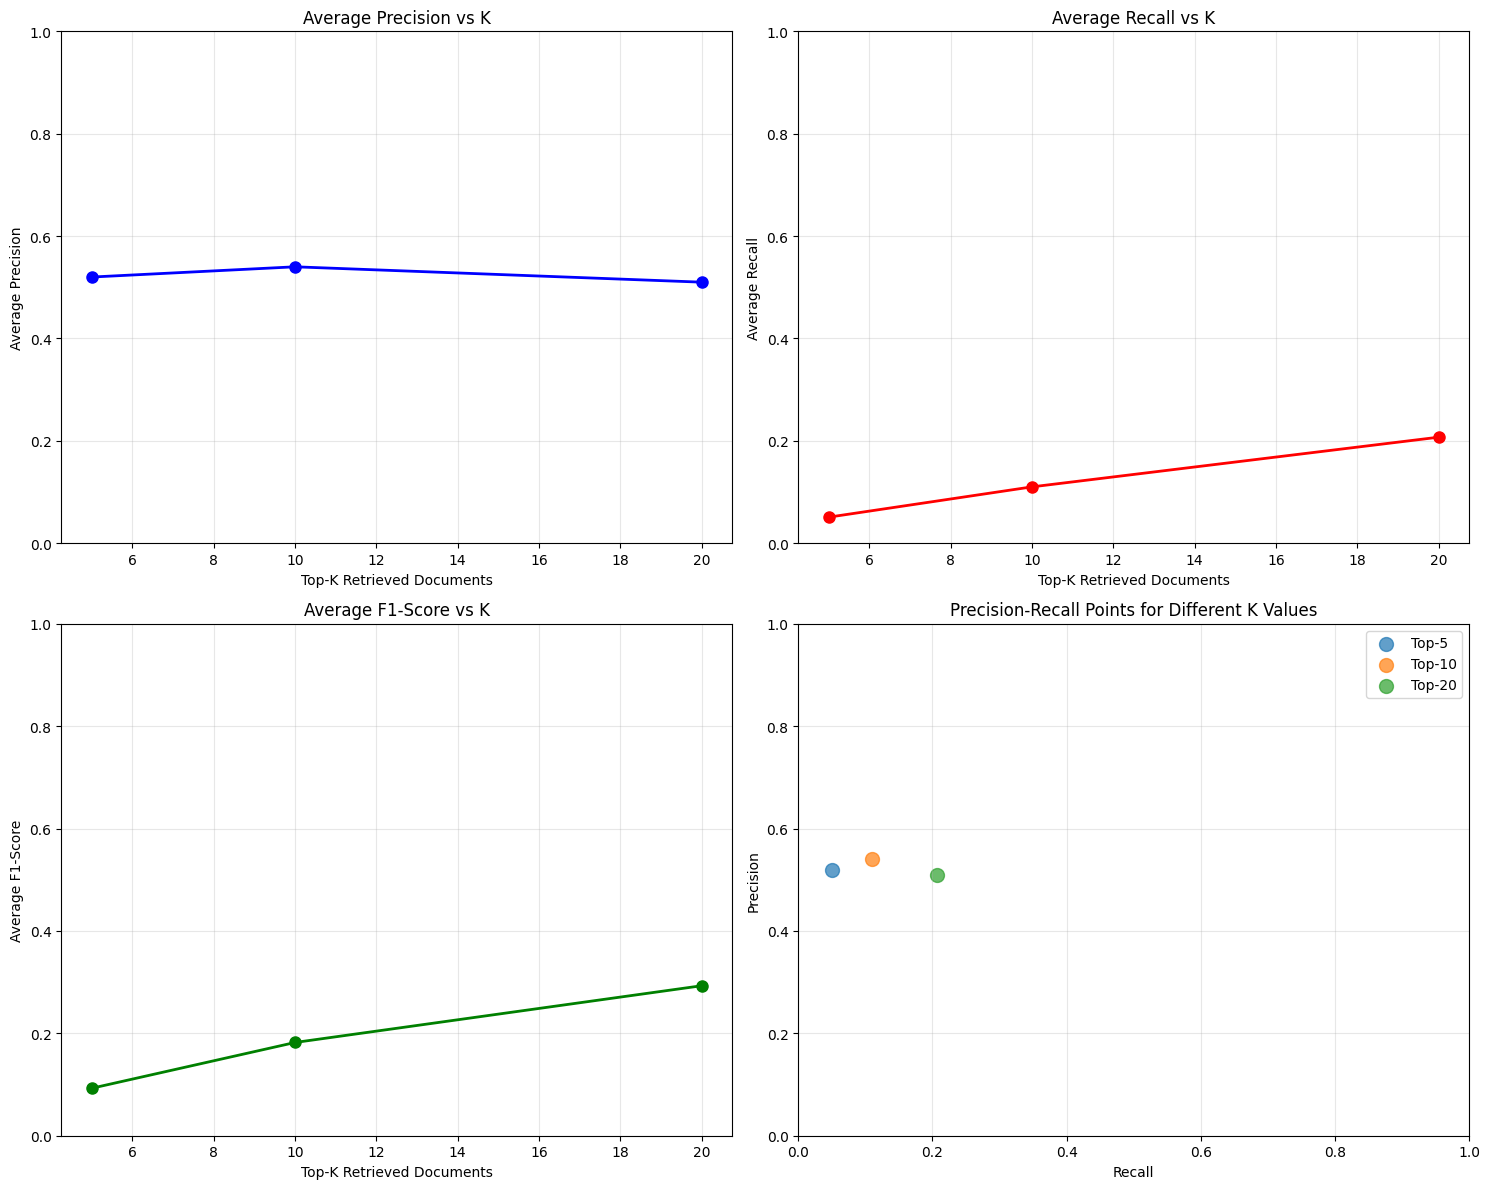


RETRIEVAL EVALUATION SUMMARY
Top-K    Avg Precision   Avg Recall   Avg F1-Score
-----------------------------------------------
5        0.520           0.051        0.093       
10       0.540           0.110        0.182       
20       0.510           0.207        0.293       

Dataset size: 1000 documents
Number of test queries: 10
Categories covered: 10


In [12]:
# Visualize the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Extract data for plotting
k_values = list(evaluation_results.keys())
precisions = [evaluation_results[k]['precision'] for k in k_values]
recalls = [evaluation_results[k]['recall'] for k in k_values]
f1_scores = [evaluation_results[k]['f1'] for k in k_values]

# Plot 1: Average Precision vs K
ax1.plot(k_values, precisions, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Top-K Retrieved Documents')
ax1.set_ylabel('Average Precision')
ax1.set_title('Average Precision vs K')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Plot 2: Average Recall vs K
ax2.plot(k_values, recalls, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Top-K Retrieved Documents')
ax2.set_ylabel('Average Recall')
ax2.set_title('Average Recall vs K')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Plot 3: Average F1-Score vs K
ax3.plot(k_values, f1_scores, 'go-', linewidth=2, markersize=8)
ax3.set_xlabel('Top-K Retrieved Documents')
ax3.set_ylabel('Average F1-Score')
ax3.set_title('Average F1-Score vs K')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Plot 4: Precision-Recall curve for different K values
for k in k_values:
    ax4.scatter(evaluation_results[k]['recall'], evaluation_results[k]['precision'], 
               s=100, label=f'Top-{k}', alpha=0.7)

ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_title('Precision-Recall Points for Different K Values')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("RETRIEVAL EVALUATION SUMMARY")
print("="*80)
print(f"{'Top-K':<8} {'Avg Precision':<15} {'Avg Recall':<12} {'Avg F1-Score':<12}")
print("-" * 47)
for k in k_values:
    precision = evaluation_results[k]['precision']
    recall = evaluation_results[k]['recall']
    f1 = evaluation_results[k]['f1']
    print(f"{k:<8} {precision:<15.3f} {recall:<12.3f} {f1:<12.3f}")

print(f"\nDataset size: {len(df_subset)} documents")
print(f"Number of test queries: {len(test_queries)}")
print(f"Categories covered: {len(set([cat for _, cat in test_queries]))}")

In [13]:
# Detailed analysis of individual queries
def analyze_query_performance(query_text, expected_category, embeddings_df, top_k=10):
    """
    Provide detailed analysis for a specific query.
    """
    print(f"Detailed Analysis for Query: '{query_text}'")
    print(f"Expected Category: {newsgroups_train.target_names[expected_category]}")
    print("=" * 80)
    
    precision, recall, results = compute_precision_recall(query_text, expected_category, embeddings_df, top_k)
    
    print(f"Precision: {precision:.3f} ({int(precision * top_k)}/{top_k} relevant documents retrieved)")
    print(f"Recall: {recall:.3f}")
    
    total_relevant = sum(embeddings_df['category'] == expected_category)
    relevant_retrieved = sum(results['category'] == expected_category)
    print(f"Total relevant documents in dataset: {total_relevant}")
    print(f"Relevant documents retrieved: {relevant_retrieved}")
    
    print(f"\nTop {top_k} Retrieved Documents:")
    print("-" * 50)
    
    for i, (_, row) in enumerate(results.iterrows(), 1):
        category_name = newsgroups_train.target_names[row['category']]
        is_relevant = "✓" if row['category'] == expected_category else "✗"
        print(f"{i:2d}. {is_relevant} Similarity: {row['similarity_score']:.3f} | Category: {category_name}")
        print(f"    Text: {row['cleaned_text'][:100]}...")
        print()

# Analyze a few specific queries in detail
print("DETAILED QUERY ANALYSIS")
print("=" * 80)

# Analyze the first few test queries
for query_text, expected_cat in test_queries[:3]:
    analyze_query_performance(query_text, expected_cat, df_subset, top_k=10)
    print("\n" + "="*80 + "\n")

DETAILED QUERY ANALYSIS
Detailed Analysis for Query: 'computer graphics and image processing'
Expected Category: comp.graphics
Precision: 0.800 (8/10 relevant documents retrieved)
Recall: 0.178
Total relevant documents in dataset: 45
Relevant documents retrieved: 8

Top 10 Retrieved Documents:
--------------------------------------------------
 1. ✓ Similarity: 0.715 | Category: comp.graphics
    Text: originator: keywords: conference reply-to: (ed breen) australian pattern recognition society 2nd cal...

 2. ✓ Similarity: 0.670 | Category: comp.graphics
    Text: distribution: world concerning the proposed newsgroup split, i personally am not in favor of doing t...

 3. ✓ Similarity: 0.656 | Category: comp.graphics
    Text: help!! i need code/package/whatever to take 3-d data and turn it into a wireframe surface with hidde...

 4. ✓ Similarity: 0.651 | Category: comp.graphics
    Text: distribution: world reply-to: (david ingebretsen) i downloaded an image of the earth re-constructed

c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Users\samue\Downloads\RAG\retrieval-augmented-generation-stack\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
